# Classify wells as filled or empty, classify images as good quality or bad quality

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from definitions import ROOT_DIR
import matplotlib.pyplot as plt
import seaborn as sns
from metaspace.sm_annotation_utils import SMInstance
from getpass import getpass
import random
import parula_black # local colormap

- Define plotting function, at the moment it pulls image from metaspace, clips to 99th percentile, rescales to 8-bit and plots using parula_black colourmap from MSIreader

In [3]:
def clip(img, bottom=0, top=99):
    """Remove bottom and top percentiles of image pixels"""
    lo = np.min(img)
    lo_thresh = np.max(img) / 256
    hi = np.percentile(img[img >= lo_thresh], top)
    img_clipped = np.clip(img, lo, hi)
    return img_clipped

def rescale(data, bottom=0, top=255):
    """Rescale data to lie between [min, max] values"""
    compressed = (data - np.min(data)) / np.max(data - np.min(data))
    rescaled = compressed * (top - bottom) + bottom
    return rescaled

def show_images(images, cols = 1, titles = None): # This function is not my code 
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        ax = fig.add_subplot(int(np.ceil(n_images/cols)), cols, n+1)
        ax.set_axis_off()
        if image.ndim == 2:
#         plt.imshow(rescale(clip(image)), cmap='viridis') # To make images look same as on METASPACE
            plt.imshow(rescale(clip(image)), cmap=parula_black.parula_map)
            ax.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

How to mark wells as occupied / not occupied? Consider the following cases.

A) Crisp spot
- occupancy_ratio is high
- on_off_ratio also high, easy case

B) Empty image or image with just a few specks
- is_empty = True (in the code above this can be assigned to images with less non-zero pixels than N)
- occupancy_ratio is 0 in all wells
- on_off_ratio is 0

C) Coffee-ring spot
- occupancy_ratio is medium
- on_off_ratio is medium

D) Bright spot with faint background everywhere
- occupancy_ratio is around 1
- on_off_ratio is high

E) Delocalised spot
- occupancy_ratio is medium-high
- on_off_ratio is medium-high

F) Multiple spots
Wells are judjed on individual basis, so shouldn't be an issue

G) Bright background, suppressed spots
- occupancy_ratio is around 1
- on_off_ratio is below 1

H) Uniform background ion
- occupancy ratio is around 1
- on_off_ratio is around 1

<img src="5_well_classification/cases.png" width="600" style="float: left;">
<img src="5_well_classification/ratio_plot.png" width="300">

- Provide inputs

In [4]:
# Paths
p_root_dir = Path(ROOT_DIR)
p_analysis = p_root_dir  / "5_well_classification"
p_stats = p_root_dir / "4_metric_extension"
p_labelled_set = p_analysis / "labelled_set"
p_datasets = p_labelled_set / "Datasets.csv"
p_out = p_analysis / "all_stats_with_classification.csv"
p_out2 = p_analysis / "only_target_wells_with_classification.csv"

# METASPACE
database = ('Spotting_project_compounds-v9', 'feb2021')
fdr = 0.5

### Prepare data

- Load and combine results of multiple datasets

In [5]:
appended_data = []

for i in p_stats.rglob("*bigreport_extended.csv"):
    
    fname = i.stem
    dataset_id = fname[-20:]    
    data = pd.read_csv(i)
    data.neutral_loss.fillna('', inplace=True)
    appended_data.append(data)

stats_all = pd.concat(appended_data)
stats_all.set_index(['formula', 'adduct', 'neutral_loss', 'dataset_id'], inplace=True)
stats_all.sort_index(inplace=True)

- Load and combine labelled sets

In [6]:
appended_data = []

for i in p_labelled_set.rglob("*Quality_Labels.csv"):

    data = pd.read_csv(i)
    data = data.loc[:, ['dataset_id', 'formula', 'adduct', 'neutral_loss', 'score']]
    data.neutral_loss.fillna('', inplace=True)
    appended_data.append(data)

test_set = pd.concat(appended_data)

- Update dataset id to a new id corresponding to a dataset now on staging

In [7]:
datasets = pd.read_csv(p_datasets)
test_set['technology'] = [datasets.loc[datasets["Dataset ID"].isin([x]), "Technology"].item() for x in test_set.dataset_id]
new_ids = [datasets.loc[datasets["Dataset ID"].isin([x]), "Clone ID"].item() for x in test_set.dataset_id]
test_set.dataset_id = new_ids

test_set.set_index(['formula', 'adduct', 'neutral_loss', 'dataset_id'], inplace=True)
test_set.sort_index(inplace=True)
test_set.score = test_set.score.astype(str)

- Map well statistics to labelled set

In [9]:
test_set2 = pd.merge(test_set, stats_all, left_index=True, right_index=True, how='inner')

# test
test_set2.head()

score           technology  \
formula   adduct neutral_loss dataset_id                                        
C10H12N2O +H                  2021-05-07_19h57m32s     1  AP-SMALDI5/Orbitrap   
                              2021-05-07_19h57m32s     1  AP-SMALDI5/Orbitrap   
                              2021-05-07_19h57m32s     1  AP-SMALDI5/Orbitrap   
                              2021-05-07_19h57m32s     1  AP-SMALDI5/Orbitrap   
                              2021-05-07_19h57m32s     1  AP-SMALDI5/Orbitrap   

                                                    well           sum  \
formula   adduct neutral_loss dataset_id                                 
C10H12N2O +H                  2021-05-07_19h57m32s     0  2.018994e+07   
                              2021-05-07_19h57m32s     2  5.476130e+04   
                              2021-05-07_19h57m32s    10  5.469571e+04   
                              2021-05-07_19h57m32s    11  4.735049e+04   
                              2021-05-07_19h57m32s    12  5.095752e+04   

                                                      average   occupancy  \
formula   adduct neutral_loss dataset_id                                    
C10H12N2O +H                  2021-05-07_19h57m32s  752.51340   98.781215   
                              2021-05-07_19h57m32s  793.64197  100.000000   
                              2021-05-07_19h57m32s  792.69150  100.000000   
                              2021-05-07_19h57m32s  686.23895   95.652174   
                              2021-05-07_19h57m32s  738.51480  100.000000   

                                                        stdev       msm  \
formula   adduct neutral_loss dataset_id                                  
C10H12N2O +H                  2021-05-07_19h57m32s  288.41556  0.234254   
                              2021-05-07_19h57m32s  271.70132  0.234254   
                              2021-05-07_19h57m32s  283.73065  0.234254   
                              2021-05-07_19h57m32s  245.28006  0.234254   
                              2021-05-07_19h57m32s  204.56080  0.234254   

                                                    is_target  is_empty  \
formula   adduct neutral_loss dataset_id                                  
C10H12N2O +H                  2021-05-07_19h57m32s      False     False   
                              2021-05-07_19h57m32s      False     False   
                              2021-05-07_19h57m32s      False     False   
                              2021-05-07_19h57m32s      False     False   
                              2021-05-07_19h57m32s      False     False   

                                                    off_sample_avg_int  \
formula   adduct neutral_loss dataset_id                                 
C10H12N2O +H                  2021-05-07_19h57m32s            752.5134   
                              2021-05-07_19h57m32s            752.5134   
                              2021-05-07_19h57m32s            752.5134   
                              2021-05-07_19h57m32s            752.5134   
                              2021-05-07_19h57m32s            752.5134   

                                                    off_sample_occupancy  \
formula   adduct neutral_loss dataset_id                                   
C10H12N2O +H                  2021-05-07_19h57m32s             98.781215   
                              2021-05-07_19h57m32s             98.781215   
                              2021-05-07_19h57m32s             98.781215   
                              2021-05-07_19h57m32s             98.781215   
                              2021-05-07_19h57m32s             98.781215   

                                                    on_off_ratio  \
formula   adduct neutral_loss dataset_id                           
C10H12N2O +H                  2021-05-07_19h57m32s      0.998673   
                              2021-05-07_19h57m32s      1.053255   
                              2021-05-07_19h57m3

- Make plots using seaborn

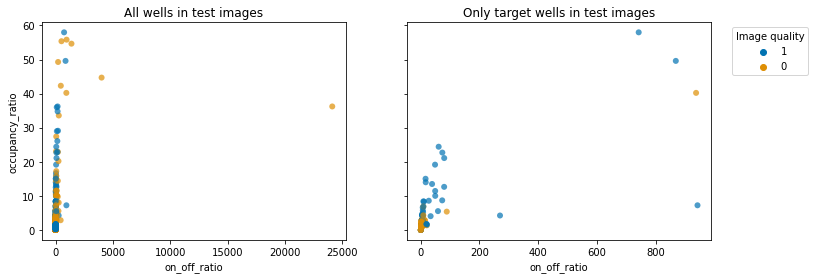

In [10]:
df = test_set2

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.set_palette(sns.color_palette("colorblind"))

# Left
sns.scatterplot(ax = axes[0], data = df, 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = 'score', 
                alpha = 0.7, linewidth = 0, legend = False)
axes[0].set_title("All wells in test images")

# Centre
sns.scatterplot(ax=axes[1], data=df[df.is_target], 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = 'score', 
                alpha = 0.7, linewidth = 0)
axes[1].set_title("Only target wells in test images")
axes[1].legend(bbox_to_anchor= (1.05, 1), title="Image quality")

plt.show()

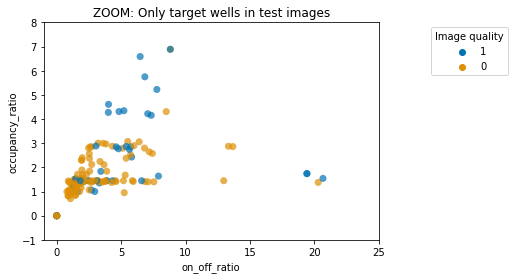

In [11]:
df = test_set2

fig = sns.scatterplot(data=df[df.is_target], 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = 'score', 
                alpha = 0.7, linewidth = 0, s=50)
fig.set_title("ZOOM: Only target wells in test images")

# set limits of axes to zoom in here:
# fig.set(xlim =(-5, 100), ylim = (-1, 20))
fig.set(xlim =(-1, 25), ylim = (-1, 8))

fig.legend(bbox_to_anchor= (1.4, 1), title="Image quality")
plt.show()

### Find a good way to threshold metrics

In [17]:
from sklearn.metrics import f1_score, accuracy_score

- Shuffle data to make a test test where x are metrics (on_off_ratio and occ_ratio) and y are well labes (1=occupied well, 0=empty well)

In [18]:
my_test_set = test_set2[test_set2.well != 0].groupby(['formula', 'adduct', 'neutral_loss', 'dataset_id']).agg(
{
    'on_off_ratio':max,
    'occupancy_ratio':max,
    'score':'first'
})

x = my_test_set[['on_off_ratio', 'occupancy_ratio']].values
y = my_test_set.score.values 

- Calculate accuracy and F1 score for all pairs of metric thresholds within some reasonable range

In [41]:
f1_image = []
accuracy_image = []

for t_occ in range(0,40):
    for t_on_off in range(0,100):
        
        y_actual = y
        y_pred = [str(1*((row[0] > t_on_off) | (row[1] > t_occ))) for row in x]
        
        f1 = f1_score(y_actual, y_pred, pos_label='1')
        f1_image.append(f1)
        accuracy = accuracy_score(y_actual, y_pred)
        accuracy_image.append(accuracy)

- Plot accuracy and F1 score for various thresholds

<IPython.core.display.Javascript object>


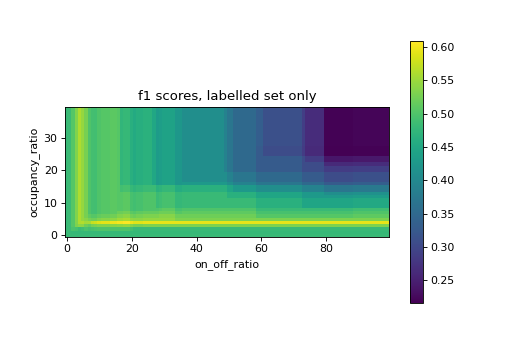

<IPython.core.display.Javascript object>


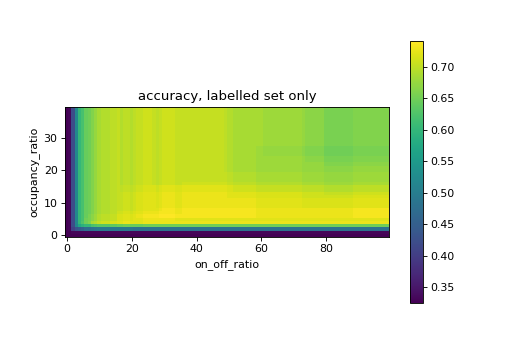

In [45]:
plt.figure()
plt.imshow(np.reshape(f1_image,(40,100)), origin='lower')
plt.title('f1 scores, labelled set only')
plt.ylabel('occupancy_ratio')
plt.xlabel('on_off_ratio')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.reshape(accuracy_image,(40,100)), origin='lower')
plt.title('accuracy, labelled set only')
plt.ylabel('occupancy_ratio')
plt.xlabel('on_off_ratio')
plt.colorbar()
plt.show()

- Pick reasonable thresholds

In [46]:
occ_thres = 20
on_off_thres = 20

- Classify all wells in all datasets based on the chosen thresholds

In [47]:
# mark wells that pass thresholds
passing_rows = (stats_all.on_off_ratio > on_off_thres) | (stats_all.occupancy_ratio > occ_thres)
stats_all['is_well_filled'] = 0
stats_all.loc[passing_rows, 'is_well_filled'] = 1

- Plot predicted classification for wells

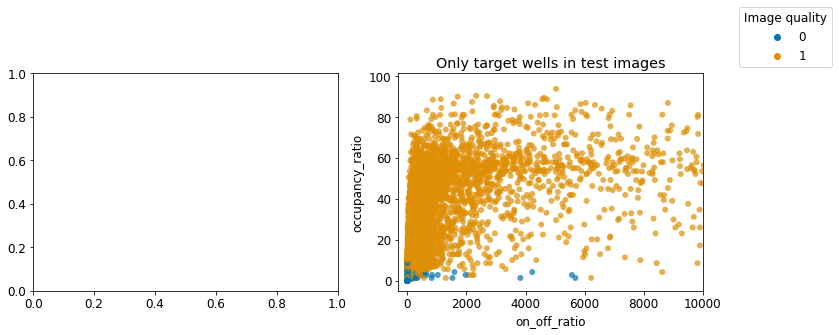

In [35]:
df = stats_all
hue = 'is_well_filled'

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

sns.set_palette(sns.color_palette("colorblind"))

# Left
sns.scatterplot(ax = axes[0], data = df, 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = hue, 
                alpha = 0.7, linewidth = 0, legend = False)
axes[0].set_title("All wells in test images")
axes[0].set(xlim = (-300, 1e4))

# Centre
sns.scatterplot(ax=axes[1], data=df[df.is_target], 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = hue, 
                alpha = 0.7, linewidth = 0)
axes[1].set_title("Only target wells in test images")
axes[1].legend(bbox_to_anchor= (1.1, 1), title="Prediction: is well filled")
axes[1].set(xlim = (-300, 1e4))

plt.show()

- Classify image as good if it has at least one filled well

In [ ]:
# Exclude 'well 0' which is background
no_bgr = stats_all.well != 0
good_images = stats_all[no_bgr].groupby(['formula', 'adduct', 'neutral_loss', 'dataset_id'])['is_well_filled'].max() == 1
stats_all['image_quality_predicted'] = 0
stats_all.loc[good_images, 'image_quality_predicted'] = 1

- Randomly sample and visualise n images that are classified to be of good or bad quality

In [36]:
good_images_p = stats_all[stats_all.image_quality_predicted == 1]
good_images_p = good_images_p.index.unique()

bad_images_p = stats_all[(stats_all.image_quality_predicted == 0) & (stats_all.is_empty !=1)]
bad_images_p = bad_images_p.index.unique()

print(f"{len(good_images_p)} images predicted as good quality, {len(bad_images_p)} non-empty images fail")

20610 images predicted as good quality, 75270 non-empty images fail


- Log in to METASPACE

In [14]:
sm = SMInstance(host='https://staging.metaspace2020.eu')
if not sm.logged_in():
    print('Enter your API key from https://metaspace2020.eu/user/me')
    sm.login(api_key=getpass())
else:
    print('Already logged in')

Enter your API key from https://metaspace2020.eu/user/me
········


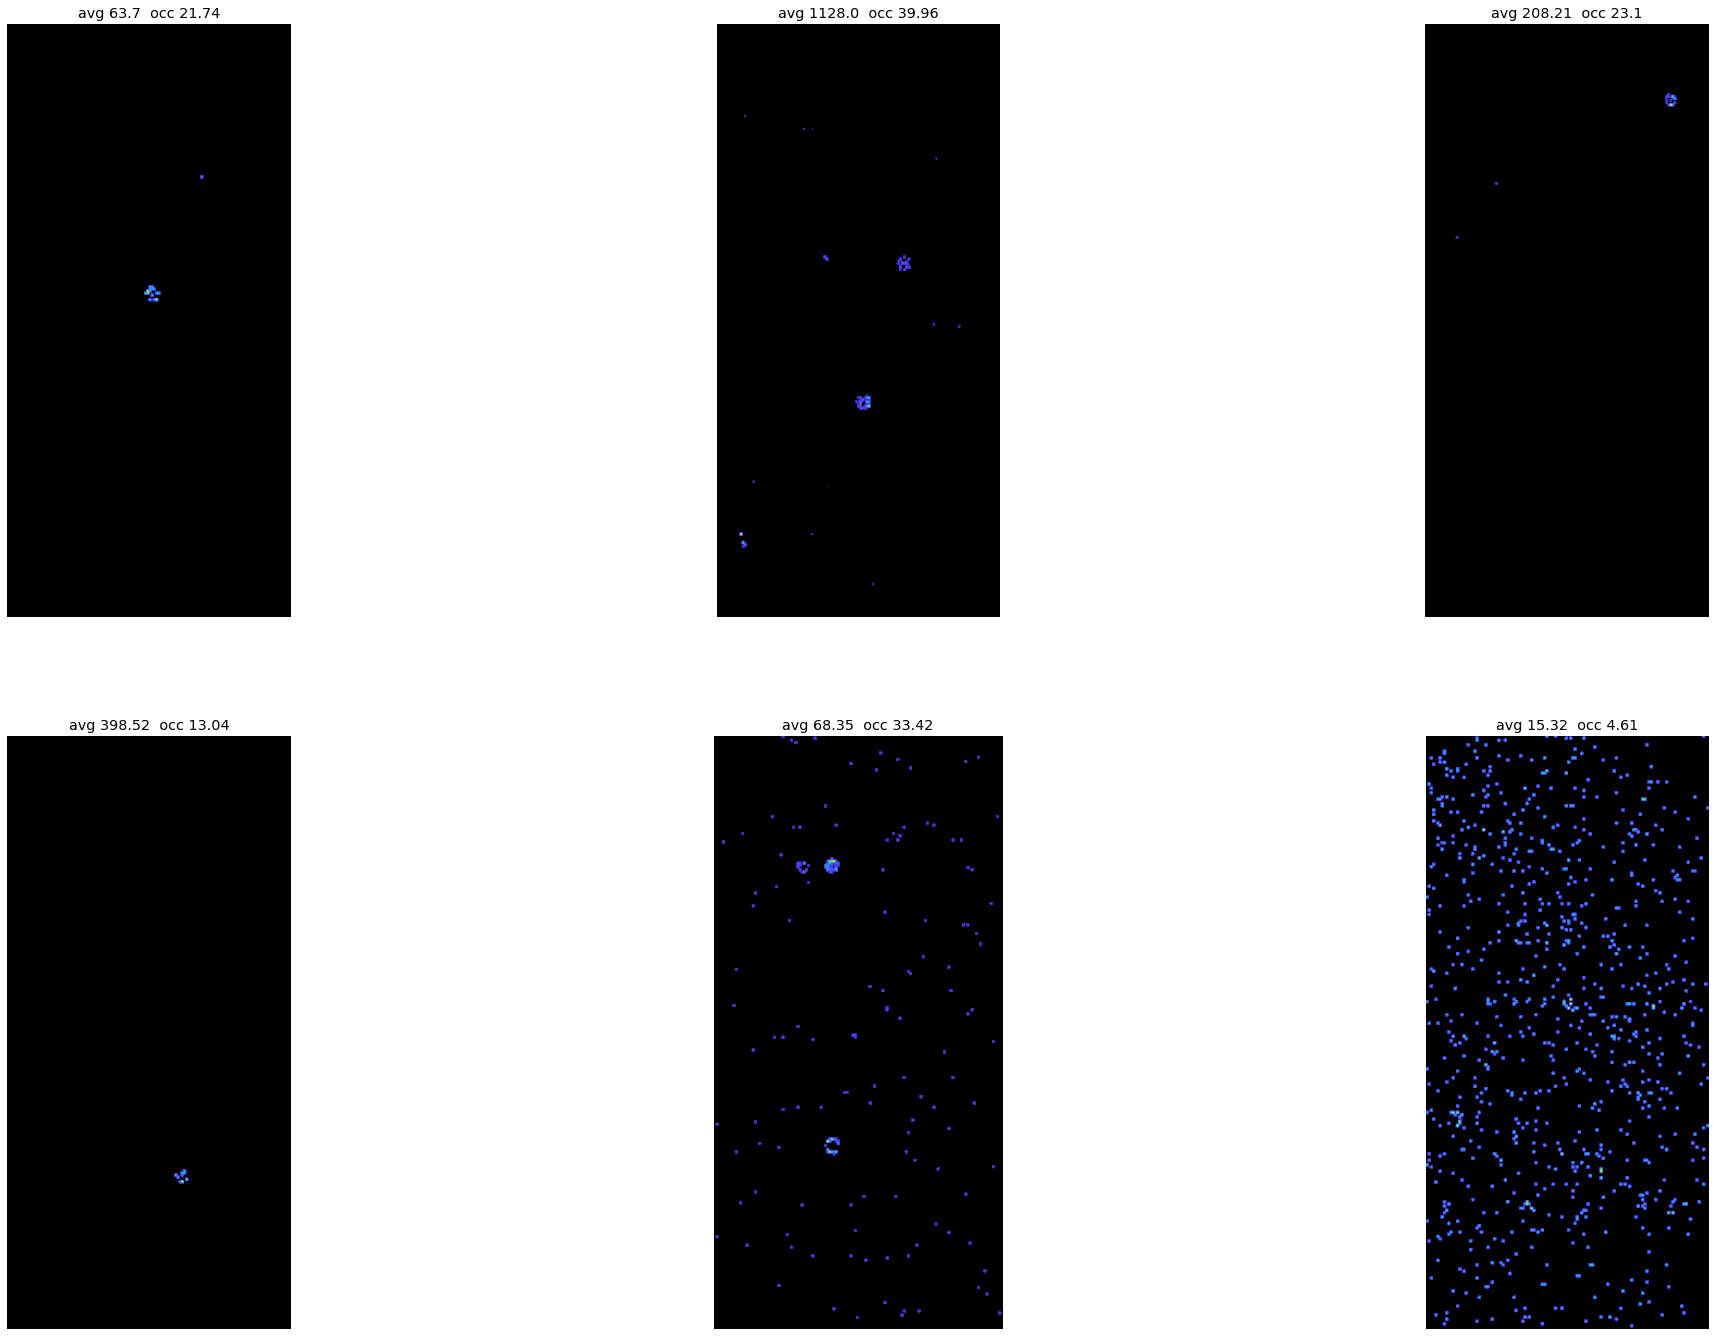

In [37]:
random_subset = random.sample(list(good_images_p), 5)

images = []
titles = []

for f, a, n, ds_id in random_subset:
    
    ds = sm.dataset(id = ds_id)
    image = ds.isotope_images(f, a, neutral_loss=n)[0]

    max_on_off_ratio = stats_all[stats_all.well != 0].loc[(f, a, n, ds_id), 'on_off_ratio'].max().round(2) # for any well in this image
    max_occ_ratio = stats_all[stats_all.well != 0].loc[(f, a, n, ds_id), 'occupancy_ratio'].max().round(2)  
    title = f"avg {max_on_off_ratio}  occ {max_occ_ratio}"
    
    images.append(image)
    titles.append(title)

plt.rcParams.update({'font.size': 12})
show_images(images=images, cols=5, titles=titles)
plt.rcParams.update({'font.size': 12}) 

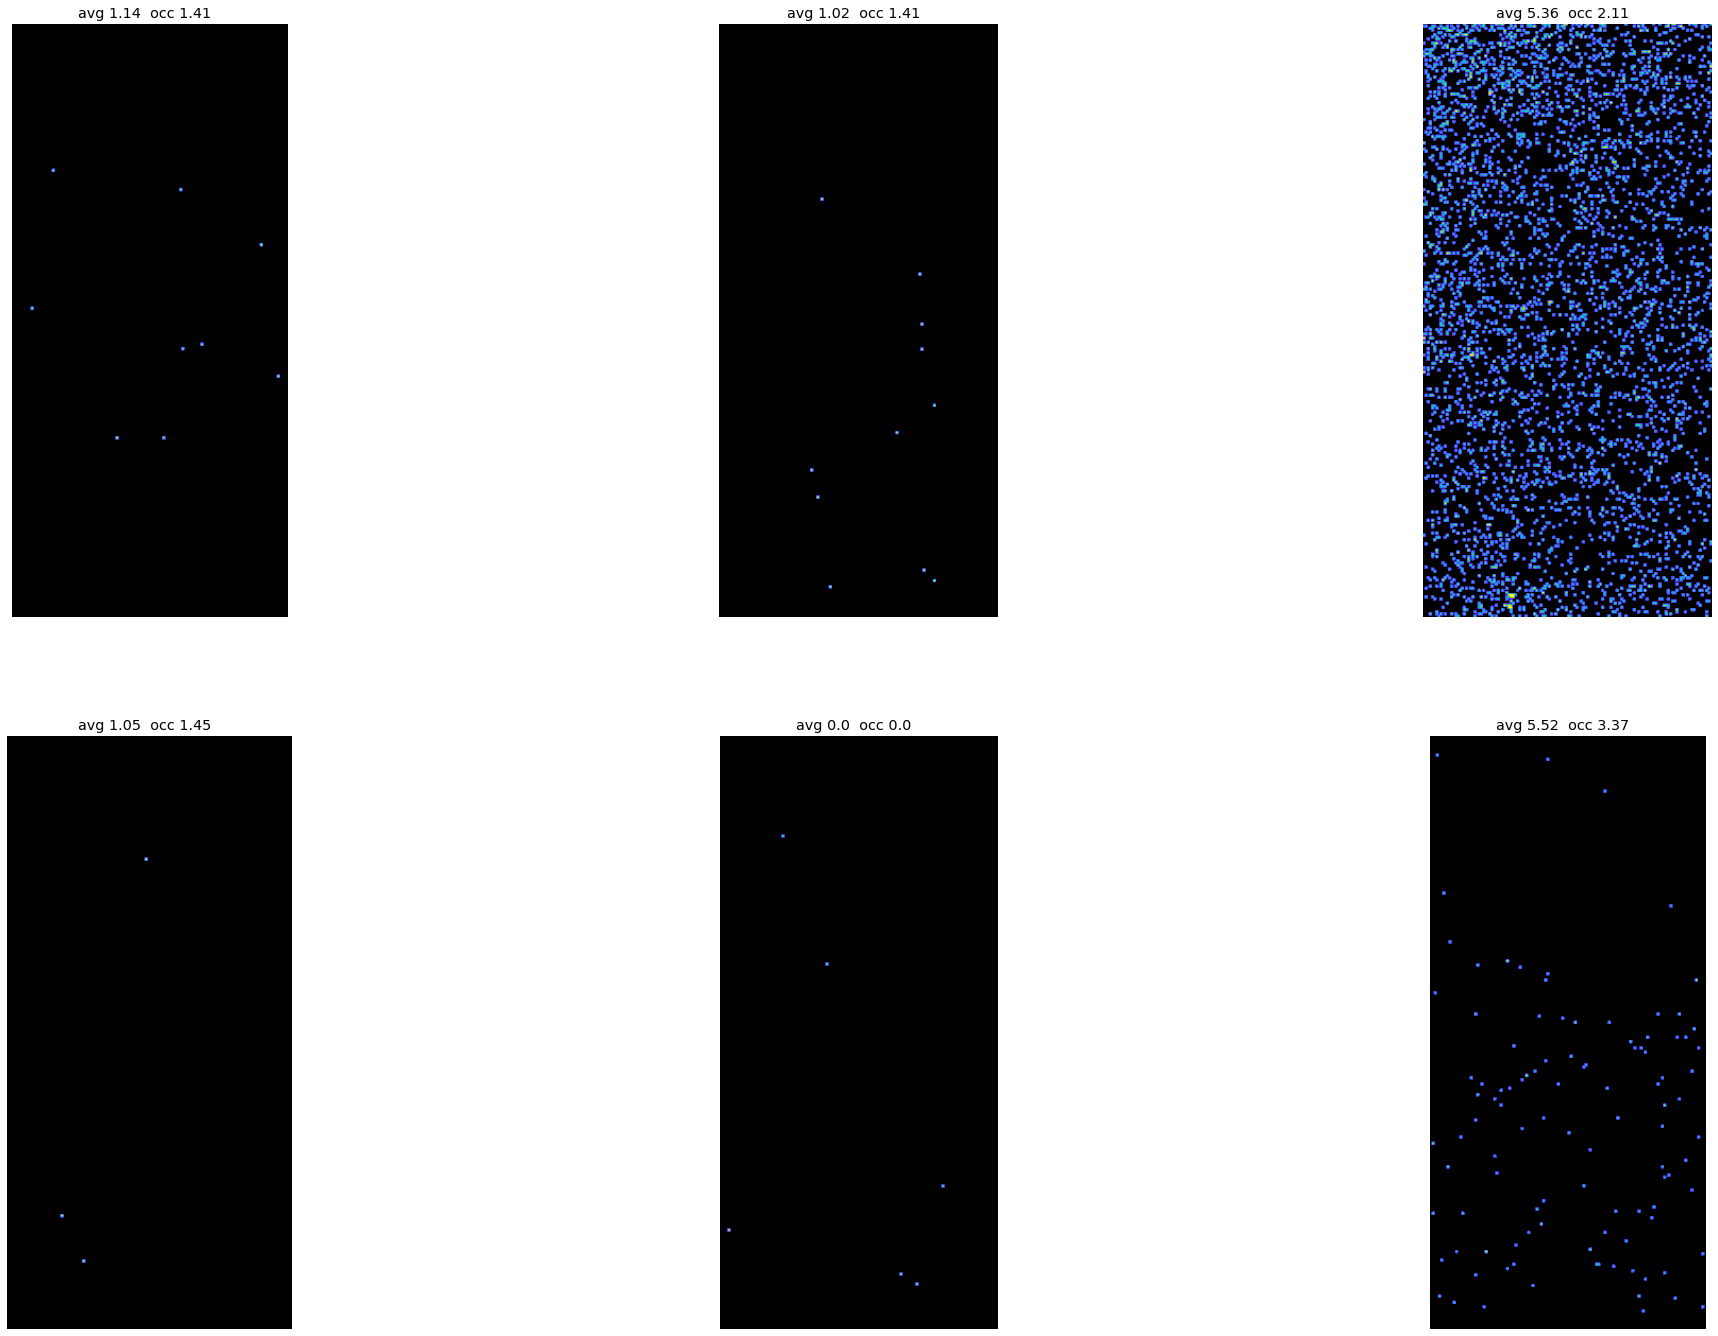

In [38]:
random_subset = random.sample(list(bad_images_p), 5)

images = []
titles = []

for f, a, n, ds_id in random_subset:
    
    ds = sm.dataset(id = ds_id)
    image = ds.isotope_images(f, a, neutral_loss=n)[0]

    max_on_off_ratio = stats_all[stats_all.well != 0].loc[(f, a, n, ds_id), 'on_off_ratio'].max().round(2) # for any well in this image
    max_occ_ratio = stats_all[stats_all.well != 0].loc[(f, a, n, ds_id), 'occupancy_ratio'].max().round(2)
    title = f"avg {max_on_off_ratio}  occ {max_occ_ratio}"
    
    images.append(image)
    titles.append(title)

plt.rcParams.update({'font.size': 12})
show_images(images=images, cols=5, titles=titles)
plt.rcParams.update({'font.size': 12}) 

- Save one file with all the metrics and predictions
- Save another file with this information only for target pairs (i.e. pairs of well and molecule that we know was spotted in that well)

In [49]:
stats_all.to_csv(p_out)

stats_target = stats_all.loc[stats_all.is_target]
stats_target.to_csv(p_out2)